In [3]:
import os
os.chdir('mmdetection')

In [4]:
# 下载压缩包
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip

--2023-02-09 15:57:07--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
正在解析主机 download.openmmlab.com (download.openmmlab.com)... 111.19.206.237, 111.19.206.234, 111.19.210.237
正在连接 download.openmmlab.com (download.openmmlab.com)|111.19.206.237|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度： 6918271 (6.6M) [application/zip]
正在保存至: “kitti_tiny.zip”

kitti_tiny.zip      100%[===================>]   6.60M  4.73MB/s    用时 1.4s    

2023-02-09 15:57:09 (4.73 MB/s) - 已保存 “kitti_tiny.zip” [6918271/6918271])



In [5]:
# 解压
!unzip kitti_tiny.zip > /dev/null

In [7]:
# 查看 kitti_tiny 的目录结构
!sudo snap install tree

[sudo] hxzh02 的密码： 


In [8]:
!tree kitti_tiny

kitti_tiny
├── training
│   ├── image_2
│   │   ├── 000000.jpeg
│   │   ├── 000001.jpeg
│   │   ├── 000002.jpeg
│   │   ├── 000003.jpeg
│   │   ├── 000004.jpeg
│   │   ├── 000005.jpeg
│   │   ├── 000006.jpeg
│   │   ├── 000007.jpeg
│   │   ├── 000008.jpeg
│   │   ├── 000009.jpeg
│   │   ├── 000010.jpeg
│   │   ├── 000011.jpeg
│   │   ├── 000012.jpeg
│   │   ├── 000013.jpeg
│   │   ├── 000014.jpeg
│   │   ├── 000015.jpeg
│   │   ├── 000016.jpeg
│   │   ├── 000017.jpeg
│   │   ├── 000018.jpeg
│   │   ├── 000019.jpeg
│   │   ├── 000020.jpeg
│   │   ├── 000021.jpeg
│   │   ├── 000022.jpeg
│   │   ├── 000023.jpeg
│   │   ├── 000024.jpeg
│   │   ├── 000025.jpeg
│   │   ├── 000026.jpeg
│   │   ├── 000027.jpeg
│   │   ├── 000028.jpeg
│   │   ├── 000029.jpeg
│   │   ├── 000030.jpeg
│   │   ├── 000031.jpeg
│   │   ├── 000032.jpeg
│   │   ├── 000033.jpeg
│   │   ├── 000034.jpeg
│   │   ├── 000035.jpeg
│   │   ├── 000036.jpeg
│   │   ├── 000037.jpeg
│   │   ├── 000038.jpeg
│   │   ├── 000039.jpeg


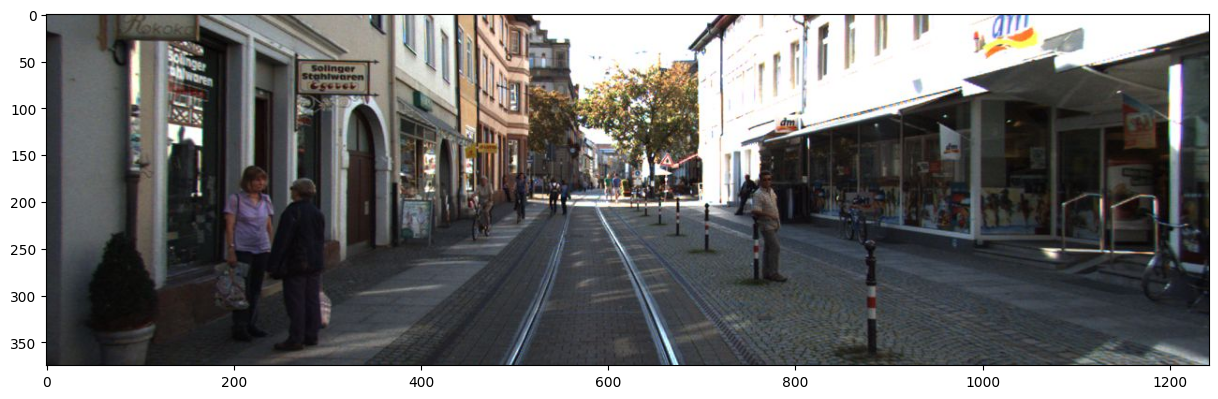

In [10]:
# 简单查看数据集的图片
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('kitti_tiny/training/image_2/000073.jpeg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [11]:
# 查看单张图的标注信息
!cat kitti_tiny/training/label_2/000073.txt

Pedestrian 0.00 0 -2.62 237.23 173.70 312.33 365.33 1.58 0.66 0.53 -2.99 1.60 6.32 -3.05
Pedestrian 0.00 1 0.80 189.46 158.23 256.19 356.44 1.70 0.61 0.51 -3.62 1.58 6.54 0.31
Pedestrian 0.00 0 0.45 752.95 164.08 791.19 288.78 1.75 0.63 0.51 2.28 1.63 10.51 0.65
Cyclist 0.00 0 1.78 444.66 170.48 485.70 241.86 1.64 0.57 2.00 -3.55 1.60 17.61 1.58
Cyclist 0.00 0 1.65 494.34 168.08 517.01 223.73 1.80 0.60 1.85 -3.54 1.66 24.31 1.51
Pedestrian 0.00 0 -2.07 546.73 177.07 560.52 214.88 1.53 0.61 0.73 -2.41 1.71 29.83 -2.15
Pedestrian 0.00 0 -2.02 535.68 174.41 549.63 214.38 1.61 0.54 0.87 -2.86 1.68 29.55 -2.12
DontCare -1 -1 -10 596.02 166.69 615.85 203.19 -1 -1 -1 -1000 -1000 -1000 -10


In [14]:
import os.path as osp
import numpy as np
import mmcv

def convert_kitti_to_middle(ann_file, out_file, img_prefix):

    CLASSES = ('Car', 'Pedestrian', 'Cyclist')
    # 类别反查表
    cat2label = {k: i for i, k in enumerate(CLASSES)}
    # 图像列表
    image_list = mmcv.list_from_file(ann_file)

    # 所有图像和标注的信息存储在一个列表中
    data_infos = []
    # convert annotations to middle format
    for image_id in image_list:
        filename = f'{img_prefix}/{image_id}.jpeg'
        image = mmcv.imread(filename)
        height, width = image.shape[:2]

        # 单张图像的信息存储在字典中
        data_info = dict(filename=f'{image_id}.jpeg', width=width, height=height)

        # 读取标注信息，并处理
        label_prefix = img_prefix.replace('image_2', 'label_2')
        lines = mmcv.list_from_file(osp.join(label_prefix, f'{image_id}.txt'))

        content = [line.strip().split(' ') for line in lines]
        bbox_names = [x[0] for x in content]
        bboxes = [[float(info) for info in x[4:8]] for x in content]

        gt_bboxes = []
        gt_labels = []
        gt_bboxes_ignore = []
        gt_labels_ignore = []

        # filter 'DontCare'
        for bbox_name, bbox in zip(bbox_names, bboxes):
            if bbox_name in cat2label:
                gt_labels.append(cat2label[bbox_name])
                gt_bboxes.append(bbox)
            else:
                gt_labels_ignore.append(-1)
                gt_bboxes_ignore.append(bbox)

        # 将标注信息（坐标和标签）转换为nparray
        data_anno = dict(
            bboxes=np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
            labels=np.array(gt_labels, dtype=np.longlong),
            bboxes_ignore=np.array(gt_bboxes_ignore,
                                    dtype=np.float32).reshape(-1, 4),
            labels_ignore=np.array(gt_labels_ignore, dtype=np.longlong))

        data_info.update(ann=data_anno)
        # 所有图像和标注的信息存储在一个列表中
        data_infos.append(data_info)
    mmcv.dump(data_infos, out_file)

convert_kitti_to_middle('kitti_tiny/train.txt', 'kitti_tiny/train_middle.pkl', 'kitti_tiny/training/image_2')
convert_kitti_to_middle('kitti_tiny/val.txt', 'kitti_tiny/val_middle.pkl', 'kitti_tiny/training/image_2')

In [15]:
from mmcv import Config
from mmdet.apis import set_random_seed

# 获取基本配置文件参数
cfg = Config.fromfile('./configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_1x_coco.py')

# 修改数据集类型以及文件路径
cfg.dataset_type = 'CustomDataset'
cfg.data_root = 'kitti_tiny/'
cfg.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.test.type = 'CustomDataset'
cfg.data.test.data_root = 'kitti_tiny/'
cfg.data.test.ann_file = 'train_middle.pkl'
cfg.data.test.img_prefix = 'training/image_2'
cfg.data.test.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.train.type = 'CustomDataset'
cfg.data.train.data_root = 'kitti_tiny/'
cfg.data.train.ann_file = 'train_middle.pkl'
cfg.data.train.img_prefix = 'training/image_2'
cfg.data.train.classes = ('Car', 'Pedestrian', 'Cyclist')

cfg.data.val.type = 'CustomDataset'
cfg.data.val.data_root = 'kitti_tiny/'
cfg.data.val.ann_file = 'val_middle.pkl'
cfg.data.val.img_prefix = 'training/image_2'
cfg.data.val.classes = ('Car', 'Pedestrian', 'Cyclist')

# 修改bbox_head中的类别数
cfg.model.roi_head.bbox_head.num_classes = 3
# 使用预训练好的faster rcnn模型用于finetuning
cfg.load_from = 'checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth'
# 设置工作目录用于存放log和临时文件
cfg.work_dir = './work_dir_custom'

# 原本的学习率是在8卡基础上训练设置的，现在单卡需要除以8
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# 由于是自定义数据集，需要修改评价方法
cfg.evaluation.metric = 'mAP'
# 设置evaluation间隔减少运行时间
cfg.evaluation.interval = 12
# 设置存档点间隔减少存储空间的消耗
cfg.checkpoint_config.interval = 12

# 固定随机种子使得结果可复现
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device = 'cuda'

# 打印所有的配置参数
# print(f'Config:\n{cfg.pretty_text}')

mmcv.mkdir_or_exist(F'{cfg.work_dir}')
cfg.dump(F'{cfg.work_dir}/customformat.py')

In [19]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# 构建数据集
datasets = [build_dataset(cfg.data.train)]

# 构建检测模型
model = build_detector(cfg.model)

# 添加类别文字属性提高可视化效果
model.CLASSES = datasets[0].CLASSES

# 创建工作目录并训练模型
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))

In [23]:
!mim download mmdet --config "faster_rcnn_r50_caffe_fpn_1x_coco"

/home/hxzh02/Package/Anaconda3/envs/mmlab1/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
processing faster_rcnn_r50_caffe_fpn_1x_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 MiB 7.9 MB/s eta 0:00:00m eta 0:00:010:00:01
Successfully downloaded faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth to /home/hxzh02/.cache/mim
Successfully dumped faster_rcnn_r50_caffe_fpn_1x_coco.py to /home/hxzh02/.cache/mim


In [26]:
# 训练模型
train_detector(model, datasets, cfg, distributed=False, validate=True)

2023-02-09 16:38:48,490 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2023-02-09 16:38:48,492 - mmdet - INFO - load checkpoint from local path: checkpoints/faster_rcnn_r50_caffe_fpn_1x_coco_bbox_mAP-0.378_20200504_180032-c5925ee5.pth
2023-02-09 16:38:48,608 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([4]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([12, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current m

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 31.1 task/s, elapsed: 1s, ETA:     0s
---------------iou_thr: 0.5---------------


2023-02-09 16:39:52,853 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 142  | 0.903  | 0.811 |
| Pedestrian | 13  | 49   | 0.846  | 0.774 |
| Cyclist    | 7   | 56   | 0.571  | 0.092 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.559 |
+------------+-----+------+--------+-------+
2023-02-09 16:39:52,891 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5590, mAP: 0.5594


/media/hxzh02/61A27B6D2B34EBF5/det_obj/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


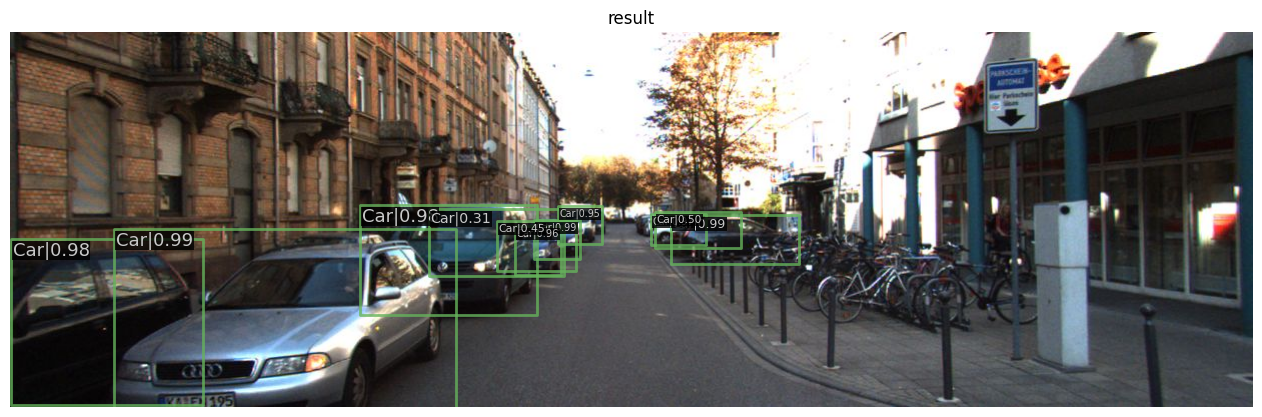

In [27]:
import mmcv
from mmdet.apis import inference_detector, show_result_pyplot

img = mmcv.imread('kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg
result = inference_detector(model, img)
show_result_pyplot(model, img, result)